# **SPICY TRAINING**

In [13]:
import tensorflow as tf

def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [14]:
# Setting che correct strategy for TPU / batch sizes
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

Running on 1 replicas
Num GPUs Available:  0
Num TPUs Available:  0


In [15]:
batch_size = 32
if numTPU != 0:
    batch_size = strategy.num_replicas_in_sync * 8

print(f"Batch size: {batch_size}")

Batch size: 32


## Data 

In [16]:
import os
import urllib.request

dataset_filename = 'cleaned_training_set.npz'

if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    directory_dataset = '/kaggle/input/blood-cells'
else:
    directory_dataset = '../data'
    if not os.path.exists(directory_dataset):
        os.makedirs(directory_dataset)
    if not os.path.exists(f'{directory_dataset}/{dataset_filename}'):
        url = "https://www.kaggle.com/datasets/camilosinning/blood-cells/download/d8yi67rTZ6HYsohjT9GN%2Fversions%2FFwagJNSFnqnnOYT5wDmO%2Ffiles%2Ftraining_set.npz?datasetVersionNumber=1"
        urllib.request.urlretrieve(url, directory_dataset)

In [17]:
import numpy as np

dataset_path = f'{directory_dataset}/{dataset_filename}'

dataset = np.load(dataset_path,allow_pickle=True)
X = dataset['images']
y = dataset['labels']

# Convert values in data to int
X = X.astype(int)

# Normalize data to the range [0, 1]
X = (X / 255).astype('float32')

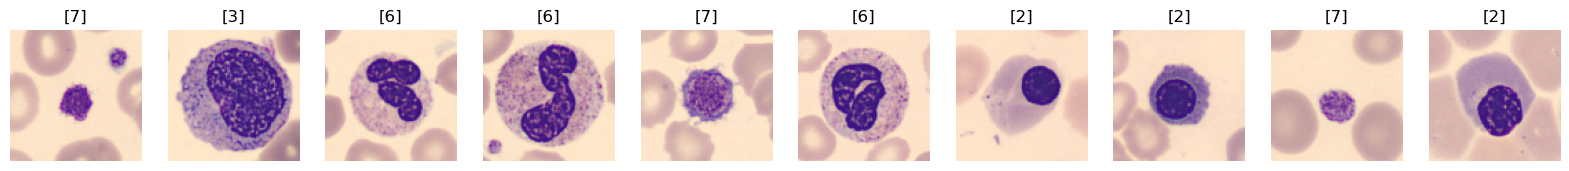

In [18]:
import matplotlib.pyplot as plt

# See the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axes[i].imshow(X[i])
    axes[i].axis('off')
    axes[i].set_title(y[i])
plt.show()

In [19]:
# Convert labels to categorical format using one-hot encoding
y = tf.keras.utils.to_categorical(y)

In [20]:
from sklearn.model_selection import train_test_split

# Split data into training, validation, and test sets, maintaining class distribution
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# Splitting the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val)

In [21]:
# Print the shapes of the training, validation, and test sets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (8610, 96, 96, 3), (8610, 8)
Validation set: (2153, 96, 96, 3), (2153, 8)
Test set: (1196, 96, 96, 3), (1196, 8)


In [22]:
del X, y, X_train_val, y_train_val

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().shuffle(4096).batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).cache().shuffle(4096).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache().shuffle(4096).batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Define constants

In [24]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

steps_per_epoch = y_train.shape[0] // batch_size

print("Input Shape: ", input_shape)
print("Output Shape: ", output_shape)
print("Steps per epoch: ", steps_per_epoch)

Input Shape:  (96, 96, 3)
Output Shape:  8
Steps per epoch:  269


## Define functions

In [ ]:
# Custom implementation of ReduceLROnPlateau
class CustomReduceLROnPlateau(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_binary_accuracy', factor=0.33, patience=20, min_lr=1e-8, verbose=1):
        super(CustomReduceLROnPlateau, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.new_lr = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        
        # Initialize best metric if it's the first epoch
        if self.best is None:
            self.best = current
            return

        # Check if the monitored metric has improved
        if current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1

            # If patience is exceeded, reduce the learning rate
            if self.wait >= self.patience:
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                if old_lr == self.min_lr:
                    return
                self.new_lr = max(old_lr * self.factor, self.min_lr)
                self.model.optimizer.learning_rate.assign(self.new_lr)
                
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: reducing learning rate to {self.new_lr}.")
                
                self.wait = 0  # Reset patience counter

In [ ]:
# Custom callback class for real-time plotting
class RealTimePlot(Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['categorical_accuracy'])
        self.val_acc.append(logs['val_categorical_accuracy'])

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        self.ax_loss.set_ylim(top=2.5, bottom=0.0)
        self.ax_loss.legend()

        # Plot training and validation accuracy
        self.ax_acc.clear()
        self.ax_acc.plot(self.epochs, self.train_acc, label='Training Accuracy')
        self.ax_acc.plot(self.epochs, self.val_acc, label='Validation Accuracy')
        self.ax_acc.set_title('Training and Validation Accuracy')
        self.ax_acc.set_xlabel('Epoch')
        self.ax_acc.set_ylabel('Accuracy')
        self.ax_acc.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)

In [ ]:
class DisplayLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the current learning rate from the optimizer and display it
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"Epoch {epoch+1} : Learning rate = {tf.keras.backend.get_value(lr)}")

## Model definition

Saidani, O., Umer, M., Alturki, N. et al. White blood cells classification using multi-fold pre-processing and optimized CNN model. Sci Rep 14, 3570 (2024). https://doi.org/10.1038/s41598-024-52880-0

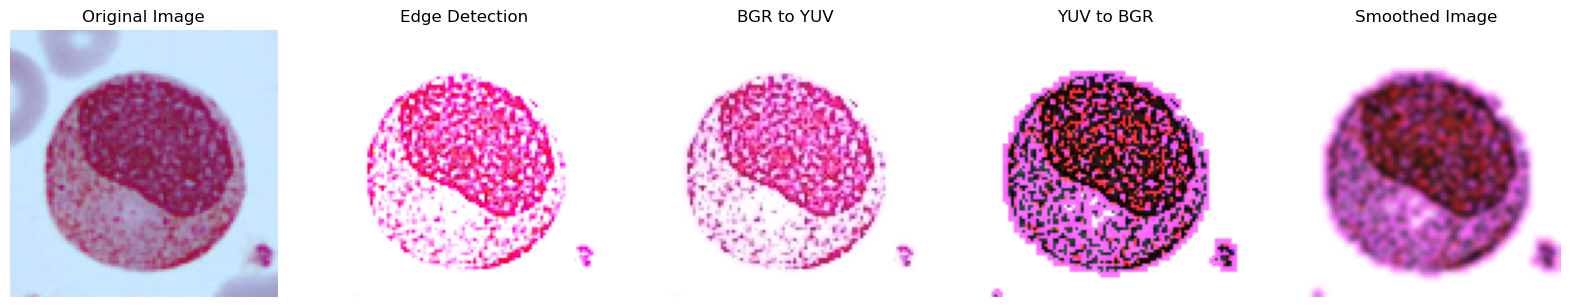

In [27]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

# Function to apply edge detection filter
def apply_edge_detection(image):
    kernel = np.array([[0, -1, 0], [-1, 6, -1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

# Function to convert BGR to YUV and reduce U and V resolution
def convert_bgr_to_yuv(image):
    yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    y, u, v = cv2.split(yuv_image)
    u = cv2.resize(u, (u.shape[1] // 2, u.shape[0] // 2))
    v = cv2.resize(v, (v.shape[1] // 2, v.shape[0] // 2))
    u = cv2.resize(u, (u.shape[1] * 2, u.shape[0] * 2))
    v = cv2.resize(v, (v.shape[1] * 2, v.shape[0] * 2))
    return cv2.merge([y, u, v])

# Function to convert YUV back to BGR
def convert_yuv_to_bgr(yuv_image):
    return cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR)

# Function to apply histogram normalization
def histogram_normalization(image):
    for i in range(3):
        image[:, :, i] = cv2.equalizeHist(image[:, :, i])
    return image

# Function to apply edge smoothing
def edge_smoothing(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

# Take the first image from the dataset
image = (X_test[0] * 255).astype(np.uint8)

# Apply edge detection
edge_detected_image = apply_edge_detection(image)

# Convert BGR to YUV and reduce U and V resolution
yuv_image = convert_bgr_to_yuv(edge_detected_image)

# Convert YUV back to BGR
bgr_image = convert_yuv_to_bgr(yuv_image)

# Apply histogram normalization
normalized_image = histogram_normalization(bgr_image)

# Apply edge smoothing
smoothed_image = edge_smoothing(normalized_image)

# Plot the images at each stage
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(edge_detected_image, cv2.COLOR_BGR2RGB))
axes[1].set_title('Edge Detection')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(yuv_image, cv2.COLOR_YUV2RGB))
axes[2].set_title('BGR to YUV')
axes[2].axis('off')

axes[3].imshow(cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB))
axes[3].set_title('YUV to BGR')
axes[3].axis('off')

axes[4].imshow(cv2.cvtColor(smoothed_image, cv2.COLOR_BGR2RGB))
axes[4].set_title('Smoothed Image')
axes[4].axis('off')

plt.show()

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
from keras.utils import register_keras_serializable

@register_keras_serializable()
class CustomImageTransformationLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomImageTransformationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        def apply_transformations(image):
            # Convert the image to uint8
            image = tf.cast(image * 255.0, tf.uint8).numpy()

            # Apply edge detection
            kernel = np.array([[0, -1, 0], [-1, 6, -1], [0, -1, 0]])
            edge_detected_image = cv2.filter2D(image, -1, kernel)

            # Convert BGR to YUV and reduce U and V resolution
            yuv_image = cv2.cvtColor(edge_detected_image, cv2.COLOR_BGR2YUV)
            y, u, v = cv2.split(yuv_image)
            u = cv2.resize(u, (u.shape[1] // 2, u.shape[0] // 2))
            v = cv2.resize(v, (v.shape[1] // 2, v.shape[0] // 2))
            u = cv2.resize(u, (u.shape[1] * 2, u.shape[0] * 2))
            v = cv2.resize(v, (v.shape[1] * 2, v.shape[0] * 2))
            yuv_image = cv2.merge([y, u, v])

            # Convert YUV back to BGR
            bgr_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR)

            # Apply histogram normalization
            for i in range(3):
                bgr_image[:, :, i] = cv2.equalizeHist(bgr_image[:, :, i])

            # Apply edge smoothing
            smoothed_image = cv2.GaussianBlur(bgr_image, (5, 5), 0)

            # Convert back to float32 and normalize to [0, 1]
            smoothed_image = tf.cast(smoothed_image, tf.float32) / 255.0

            return smoothed_image

        # Apply the transformations to each image in the batch
        transformed_images = tf.map_fn(lambda img: tf.py_function(apply_transformations, [img], tf.float32), inputs)

        return transformed_images

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

def create_model(input_shape, output_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = CustomImageTransformationLayer()(inputs)
    
    # Preprocess the inputs for InceptionV3
    x = preprocess_input(x)
    
    # Add InceptionV3 model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    x = base_model(x, training=False)
    
    # Add global average pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Add a dense layer for classification
    outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    loss = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['categorical_accuracy'])
    
    return model

In [ ]:
with strategy.scope():
    model = create_model(input_shape, output_shape)
    
model.summary()

In [ ]:
import tensorflow.keras as tfk

# Define the patience value for early stopping
patience = 35

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=patience,
    restore_best_weights=True
)

# Create a ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint_callback = tfk.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1,
    save_weights_only=True
)

lr_reducer = CustomReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, min_lr=1e-8)
plot_callback = RealTimePlot()

# Store the callbacks in a list
callbacks = [early_stopping, plot_callback, lr_reducer, DisplayLearningRateCallback(), checkpoint_callback]

In [ ]:
epochs = 200

# Train the model with early stopping callback
history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    shuffle=True,
    callbacks=callbacks
).history

## Fine tunning